In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from dipy.io.image import save_nifti
import numpy as np
import learning
from dipy.data import read_stanford_hardi, read_stanford_pve_maps
import torch
import torch.nn as nn
from syn_data import SynDiffData
from water_correction import dehydrate
from dipy.segment.mask import median_otsu

from scipy.ndimage.morphology import binary_erosion

In [4]:
img, gtab = read_stanford_hardi()
dwi = img.get_data()
(csf, gm, wm) = [map.get_data()==1.0 for map in read_stanford_pve_maps()]

v_mask = np.zeros(csf.shape)
(x,y,z) = np.divide(csf.shape,2).astype(np.int)
v_mask[x-15:x+15,y-20:y+20,z-5:z+5] = 1
csf = np.logical_and(csf, v_mask)

wm[:,:,:25] = 0
gm[:,:,:25] = 0

csf, gm, wm = [binary_erosion(map) for map in (csf, gm, wm)]

save_nifti('csf', csf.astype(np.int), np.eye(4))
save_nifti('gm', gm.astype(np.int), np.eye(4))
save_nifti('wm', wm.astype(np.int), np.eye(4))
save_nifti('dwi', dwi, np.eye(4))


maskdata, mask = median_otsu(dwi, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 


In [5]:
synDataLoader = SynDiffData(gtab, dwi, csf_mask=csf, gm_mask=gm, wm_mask=wm)
syn_diff_data, water_fraction = synDataLoader.create_waterfraction_data(sample_size=25000) # this may take a while

net = learning.Net(synDataLoader.datashape, 1)

optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
num_epochs = 100
criterion = nn.MSELoss()

learning.train(syn_diff_data, water_fraction, net, criterion, num_epochs, optimizer)

Epoch 0: MSE=0.002400724662037828, ME=0.04113898751269893
Epoch 10: MSE=0.0023170293758813985, ME=0.04157014043072388
Epoch 20: MSE=0.0014130659938982135, ME=0.030904254371824025
Epoch 30: MSE=0.001308921644078815, ME=0.02950423928507629
Epoch 40: MSE=0.0010595695863147142, ME=0.02592186750724985
Epoch 50: MSE=0.0010735346189865715, ME=0.026089797002196866
Epoch 60: MSE=0.0010806930913777582, ME=0.02622597265846884
Epoch 70: MSE=0.0009974167286169009, ME=0.024970935276795586
Epoch 80: MSE=0.0009328404000152389, ME=0.0239456428498183
Epoch 90: MSE=0.0008780132175766372, ME=0.02297759994816689


(0.0008780132175766372, 0.02297759994816689)

In [6]:
water_fraction, water_corrected = dehydrate(maskdata, mask, synDataLoader, net)

/Users/leon/PycharmProjects/fwe_public/syn_data.py:188: RuntimeWarning: divide by zero encountered in true_divide
  edw = voxels / np.expand_dims(S0, axis=1)
/Users/leon/PycharmProjects/fwe_public/syn_data.py:188: RuntimeWarning: invalid value encountered in true_divide
  edw = voxels / np.expand_dims(S0, axis=1)
/Users/leon/PycharmProjects/fwe_public/water_correction.py:15: RuntimeWarning: divide by zero encountered in true_divide
  S_orig = np.divide(S_orig, b0)
/Users/leon/PycharmProjects/fwe_public/water_correction.py:15: RuntimeWarning: invalid value encountered in true_divide
  S_orig = np.divide(S_orig, b0)
/Users/leon/PycharmProjects/fwe_public/water_correction.py:28: RuntimeWarning: divide by zero encountered in true_divide
  S_corr = np.divide(S_orig - S_watercompartment, np.expand_dims(1-f, axis=1))
/Users/leon/PycharmProjects/fwe_public/water_correction.py:30: RuntimeWarning: invalid value encountered in multiply
  S_corr = np.multiply(S_corr, b0)
/Users/leon/PycharmProject

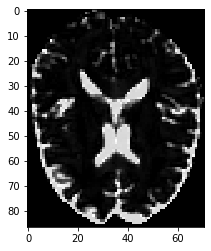

In [7]:
plt.figure('water fraction')
plt.imshow(water_fraction[:,:,30].T, cmap='gray')
plt.show()